In [366]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from datetime import datetime
import numpy as np
import re
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import (cross_val_score, train_test_split, 
                                     KFold, GridSearchCV)

In [67]:
url = 'https://www.boxofficemojo.com/chart/mpaa_title_lifetime_gross/?by_mpaa=R&offset=800'

response = requests.get(url)
page = response.text

soup = BeautifulSoup(page, 'lxml')

In [68]:
table = soup.find('table')
rows = [row for row in table.find_all('tr')]

In [69]:
movies = {}

for row in rows[1:201]:
    items = row.find_all('td')
    link = items[0].find('a')
    title, url = link.text, link['href']
    movies[title] = [url] + [i.text for i in items]
    
movies

{'Hostage': ['/title/tt0340163/?ref_=bo_cso_table_1',
  'Hostage',
  '801',
  '$34,639,939',
  '2,488',
  '2005'],
 'Man on the Moon': ['/title/tt0125664/?ref_=bo_cso_table_2',
  'Man on the Moon',
  '802',
  '$34,607,430',
  '2,489',
  '1999'],
 'Mississippi Burning': ['/title/tt0095647/?ref_=bo_cso_table_3',
  'Mississippi Burning',
  '803',
  '$34,603,943',
  '2,491',
  '1988'],
 'Monster': ['/title/tt0340855/?ref_=bo_cso_table_4',
  'Monster',
  '804',
  '$34,469,210',
  '2,496',
  '2003'],
 'The Doors': ['/title/tt0101761/?ref_=bo_cso_table_5',
  'The Doors',
  '805',
  '$34,416,893',
  '2,498',
  '1991'],
 'Eternal Sunshine of the Spotless Mind': ['/title/tt0338013/?ref_=bo_cso_table_6',
  'Eternal Sunshine of the Spotless Mind',
  '806',
  '$34,400,301',
  '2,499',
  '2004'],
 'The Foreigner': ['/title/tt1615160/?ref_=bo_cso_table_7',
  'The Foreigner',
  '807',
  '$34,393,507',
  '2,500',
  '2017'],
 'The Favourite': ['/title/tt5083738/?ref_=bo_cso_table_8',
  'The Favourite',


In [70]:
r_movies = pd.DataFrame(movies).T  #transpose
r_movies.columns = ['link_stub', 'movie_title', 'rank_g_movies', 
                    'lifetime_gross', 'rank_overall', 'year']

r_movies.head()

,link_stub,movie_title,rank_g_movies,lifetime_gross,rank_overall,year
Hostage,/title/tt0340163/?ref_=bo_cso_table_1,Hostage,801,"$34,639,939","2,488",2005
Man on the Moon,/title/tt0125664/?ref_=bo_cso_table_2,Man on the Moon,802,"$34,607,430","2,489",1999
Mississippi Burning,/title/tt0095647/?ref_=bo_cso_table_3,Mississippi Burning,803,"$34,603,943","2,491",1988
Monster,/title/tt0340855/?ref_=bo_cso_table_4,Monster,804,"$34,469,210","2,496",2003
The Doors,/title/tt0101761/?ref_=bo_cso_table_5,The Doors,805,"$34,416,893","2,498",1991


In [38]:
import dateutil.parser

def money_to_int(moneystring):
    moneystring = moneystring.replace('$', '').replace(',', '')
    return int(moneystring)

def runtime_to_minutes(runtimestring):
    runtime = runtimestring.split()
    try:
        minutes = int(runtime[0])*60 + int(runtime[2])
        return minutes
    except:
        return None

def to_date(datestring):
    date = dateutil.parser.parse(datestring)
    return date

In [39]:
def get_movie_value(soup, field_name):
    
    '''Grab a value from Box Office Mojo HTML
    
    Takes a string attribute of a movie on the page and returns the string in
    the next sibling object (the value for that attribute) or None if nothing is found.
    '''
    
    obj = soup.find(text=re.compile(field_name))
    
    if not obj: 
        return None
    
    # this works for most of the values
    next_element = obj.findNext()
    
    if next_element:
        return next_element.text 
    else:
        return None

In [40]:
def get_movie_dict(link):
    
    base_url = 'https://www.boxofficemojo.com'
    
    #Create full url to scrape
    url = base_url + link
    
    #Request HTML and parse
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page,"lxml")

    
    headers = ['movie_title', 'domestic_total_gross', 'international_total_gross', 'worldwide_total_gross',
               'opening', 'budget','runtime_minutes', 'genres', 'rating', 'release_date']
    
    #Get title
    title_string = soup.find('title').text
    title = title_string.split('-')[0].strip()

    #Get domestic gross
    raw_domestic_total_gross = (soup.find(class_='mojo-performance-summary-table')
                                    .find_all('span', class_='money')[0]
                                    .text
                               )
    domestic_total_gross = money_to_int(raw_domestic_total_gross)
    
    #Get international gross
    raw_international_total_gross = (soup.find(class_='mojo-performance-summary-table')
                                    .find_all('span', class_='money')[1]
                                    .text
                               )
    international_total_gross = money_to_int(raw_international_total_gross)
    
    #Get worldwide gross
    raw_worldwide_total_gross = (soup.find(class_='mojo-performance-summary-table')
                                    .find_all('span', class_='money')[-1]
                                    .text
                               )
    worldwide_total_gross = money_to_int(raw_worldwide_total_gross)
    
    #Get Domestic Opening 
    opening = get_movie_value(soup, 'Domestic Opening')
    
    #Get Budget
    budget = get_movie_value(soup, 'Budget')
    
    #Get runtime
    raw_runtime = get_movie_value(soup,'Running')
    runtime = runtime_to_minutes(raw_runtime)
    
    #Get Genres
    genres = get_movie_value(soup, 'Genres')
    
    #Get rating
    rating = get_movie_value(soup,'MPAA')

    #Get release date
    raw_release_date = get_movie_value(soup,'Release Date').split('\n')[0]
    release_date = to_date(raw_release_date)
    
    #Create movie dictionary and return
    movie_dict = dict(zip(headers, [title,
                                domestic_total_gross,
                                international_total_gross,
                                worldwide_total_gross,
                                opening,
                                budget,
                                runtime,
                                genres,    
                                rating, 
                                release_date]))

    return movie_dict

In [71]:
r_movies_page_info_list = []

for link in r_movies.link_stub:
    r_movies_page_info_list.append(get_movie_dict(link))

In [72]:
r_movies_page_info = pd.DataFrame(r_movies_page_info_list)  #convert list of dict to df
r_movies_page_info.set_index('movie_title', inplace=True)

r_movies_page_info

,domestic_total_gross,international_total_gross,worldwide_total_gross,opening,budget,runtime_minutes,genres,rating,release_date
movie_title,,,,,,,,,
Hostage,34639939,43023617,77663556,"$9,800,000",None,113.0,Action\n \n Crime\n \n Dra...,R,2005-03-10
Man on the Moon,34607430,12827000,47434430,"$7,515,585","$82,000,000",118.0,Biography\n \n Comedy\n \n ...,R,1999-12-22
Mississippi Burning,34603943,34603943,34603943,"$225,034",None,128.0,Crime\n \n Drama\n \n Hist...,None,1988-12-09
Monster,34469210,24000000,58469210,"$86,831","$8,000,000",109.0,Biography\n \n Crime\n \n ...,R,2003-12-24
The Doors,34416893,34416893,34416893,"$9,151,800",None,140.0,Biography\n \n Drama\n \n ...,R,1991-03-01
...,...,...,...,...,...,...,...,...,...
Sinister 2,27740955,25588195,53329150,"$10,542,116","$10,000,000",97.0,Horror\n \n Mystery\n \n T...,R,2015-08-19
Internal Affairs,27734391,27734391,27734391,"$5,043,516",None,115.0,Crime\n \n Drama\n \n Thri...,None,1990-01-12
Oculus,27695246,16764705,44459951,"$12,005,402","$5,000,000",104.0,Horror\n \n Mystery,R,2014-04-09


In [73]:
df4 = pd.merge(r_movies, r_movies_page_info, on='movie_title')

# First Data Set 1-200

In [33]:
df

,link_stub,movie_title,rank_g_movies,lifetime_gross,rank_overall,year,domestic_total_gross,international_total_gross,worldwide_total_gross,opening,budget,runtime_minutes,genres,rating,release_date
0,/title/tt0335345/?ref_=bo_cso_table_1,The Passion of the Christ,1,"$370,782,930",47,2004,370782930,241271576,612054506,"$83,848,082","$30,000,000",127.0,Drama,R,2004-02-25
1,/title/tt1431045/?ref_=bo_cso_table_2,Deadpool,2,"$363,070,709",51,2016,363070709,419766082,782836791,"$132,434,639","$58,000,000",108.0,Action\n \n Adventure\n \n ...,R,2016-02-09
2,/title/tt2179136/?ref_=bo_cso_table_3,American Sniper,3,"$350,126,372",56,2014,350126372,197300000,547426372,"$633,456","$58,800,000",133.0,Action\n \n Biography\n \n ...,R,2014-12-25
3,/title/tt7286456/?ref_=bo_cso_table_4,Joker,4,"$335,451,311",62,2019,335451311,738968073,1074419384,"$96,202,337","$55,000,000",122.0,Crime\n \n Drama\n \n Thri...,R,2019-10-02
4,/title/tt1396484/?ref_=bo_cso_table_5,It,5,"$328,828,874",69,2017,328828874,372967570,701796444,"$123,403,419","$35,000,000",135.0,Horror,R,2017-09-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,/title/tt0112740/?ref_=bo_cso_table_196,Crimson Tide,196,"$91,387,195",837,1995,91387195,66000000,157387195,"$18,612,190",None,116.0,Action\n \n Drama\n \n Thr...,R,1995-05-12
194,/title/tt0183505/?ref_=bo_cso_table_197,"Me, Myself & Irene",197,"$90,570,999",849,2000,90570999,58700000,149270999,"$24,209,385","$51,000,000",116.0,Comedy,R,2000-06-23
195,/title/tt2561572/?ref_=bo_cso_table_198,Get Hard,198,"$90,411,453",854,2015,90411453,21300000,111711453,"$33,803,253","$40,000,000",100.0,Comedy\n \n Crime,R,2015-03-26
196,/title/tt0086465/?ref_=bo_cso_table_199,Trading Places,199,"$90,404,800",855,1983,90404800,90404800,90404800,"$7,348,200",None,116.0,Comedy,None,1983-06-10


# Second Data Set 201-400

In [50]:
df1

,link_stub,movie_title,rank_g_movies,lifetime_gross,rank_overall,year,domestic_total_gross,international_total_gross,worldwide_total_gross,opening,budget,runtime_minutes,genres,rating,release_date
0,/title/tt4160708/?ref_=bo_cso_table_1,Don't Breathe,201,"$89,217,875",866,2016,89217875,68543127,157761002,"$26,411,706","$9,900,000",88.0,Crime\n \n Horror\n \n Thr...,R,2016-08-25
1,/title/tt0134084/?ref_=bo_cso_table_2,Scream 3,202,"$89,143,175",867,2000,89143175,72691101,161834276,"$34,713,342","$40,000,000",116.0,Horror\n \n Mystery,R,2000-02-04
2,/title/tt1142988/?ref_=bo_cso_table_3,The Ugly Truth,203,"$88,915,214",869,2009,88915214,232767386,321682600,"$27,605,576","$38,000,000",96.0,Comedy\n \n Romance,R,2009-02-26
3,/title/tt0454848/?ref_=bo_cso_table_4,Inside Man,204,"$88,513,495",873,2006,88513495,97490096,186003591,"$28,954,945","$45,000,000",129.0,Crime\n \n Drama\n \n Myst...,R,2006-03-23
4,/title/tt0104389/?ref_=bo_cso_table_5,The Hand that Rocks the Cradle,205,"$88,036,683",878,1992,88036683,88036683,88036683,"$7,675,016",None,110.0,Drama\n \n Thriller,R,1992-01-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,/title/tt0889583/?ref_=bo_cso_table_196,Brüno,396,"$60,054,530","1,425",2009,60054530,78751301,138805831,"$30,619,130",None,81.0,Comedy,R,2009-07-08
195,/title/tt0343737/?ref_=bo_cso_table_197,The Good Shepherd,397,"$59,952,835","1,429",2006,59952835,40314030,100266865,"$9,912,110",None,167.0,Drama\n \n History\n \n Th...,R,2006-12-22
196,/title/tt0449059/?ref_=bo_cso_table_198,Little Miss Sunshine,398,"$59,891,098","1,432",2006,59891098,41167856,101058954,"$370,998","$8,000,000",101.0,Comedy\n \n Drama,R,2006-07-26
197,/title/tt0093773/?ref_=bo_cso_table_199,Predator,399,"$59,735,548","1,435",1987,59735548,38532910,98268458,"$12,031,638","$15,000,000",107.0,Action\n \n Adventure\n \n ...,None,1987-06-12


# Third Data Set 401-600

In [58]:
df2

,link_stub,movie_title,rank_g_movies,lifetime_gross,rank_overall,year,domestic_total_gross,international_total_gross,worldwide_total_gross,opening,budget,runtime_minutes,genres,rating,release_date
0,/title/tt0348836/?ref_=bo_cso_table_1,Gothika,401,"$59,694,580","1,439",2003,59694580,81896744,141591324,"$19,288,438","$40,000,000",98.0,Horror\n \n Mystery\n \n T...,R,2003-11-21
1,/title/tt1645170/?ref_=bo_cso_table_2,The Dictator,402,"$59,650,222","1,441",2012,59650222,119729311,179379533,"$17,435,092","$65,000,000",83.0,Comedy,R,2012-05-16
2,/title/tt0102266/?ref_=bo_cso_table_3,The Last Boy Scout,403,"$59,509,925","1,443",1991,59509925,59509925,59509925,"$7,923,669",None,105.0,Action\n \n Comedy\n \n Cr...,R,1991-12-13
3,/title/tt2278388/?ref_=bo_cso_table_4,The Grand Budapest Hotel,404,"$59,301,324","1,446",2014,59301324,113644426,172945750,"$811,166","$25,000,000",99.0,Adventure\n \n Comedy\n \n ...,R,2014-02-26
4,/title/tt0115956/?ref_=bo_cso_table_5,Courage Under Fire,405,"$59,031,057","1,449",1996,59031057,41829761,100860818,"$12,501,586",None,116.0,Action\n \n Drama\n \n Mys...,R,1996-07-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,/title/tt1259528/?ref_=bo_cso_table_196,Den of Thieves,596,"$44,947,622","1,949",2018,44947622,35562000,80509622,"$15,206,108",None,140.0,Action\n \n Crime\n \n Dra...,R,2018-01-18
193,/title/tt1666185/?ref_=bo_cso_table_197,All Eyez on Me,597,"$44,922,302","1,952",2017,44922302,10746396,55668698,"$26,435,354","$40,000,000",139.0,Biography\n \n Drama\n \n ...,R,2017-06-15
194,/title/tt0077504/?ref_=bo_cso_table_198,The End,598,"$44,917,151","1,953",1978,44917151,44917151,44917151,None,None,100.0,Comedy\n \n Drama,None,1978-05-10
195,/title/tt1385867/?ref_=bo_cso_table_199,Cop Out,599,"$44,875,481","1,955",2010,44875481,10735520,55611001,"$18,211,126","$30,000,000",107.0,Action\n \n Comedy\n \n Crime,R,2010-02-26


# Fourth Data Set 601-800

In [66]:
df3

,link_stub,movie_title,rank_g_movies,lifetime_gross,rank_overall,year,domestic_total_gross,international_total_gross,worldwide_total_gross,opening,budget,runtime_minutes,genres,rating,release_date
0,/title/tt0111438/?ref_=bo_cso_table_1,Timecop,601,"$44,853,581","1,957",1994,44853581,56793000,101646581,"$12,064,625",None,99.0,Action\n \n Crime\n \n Sci...,R,1994-09-16
1,/title/tt1206885/?ref_=bo_cso_table_2,Rambo: Last Blood,602,"$44,819,352","1,958",2019,44819352,46671001,91490353,"$18,872,919","$50,000,000",89.0,Action\n \n Thriller,R,2019-09-18
2,/title/tt0093629/?ref_=bo_cso_table_3,A Nightmare on Elm Street 3: Dream Warriors,603,"$44,793,222","1,960",1987,44793222,44793222,44793222,"$8,880,555",None,96.0,Fantasy\n \n Horror,None,1987-02-27
3,/title/tt0107034/?ref_=bo_cso_table_4,The Good Son,604,"$44,789,789","1,961",1993,44789789,15823219,60613008,"$12,520,305",None,87.0,Drama\n \n Thriller,R,1993-09-24
4,/title/tt0064665/?ref_=bo_cso_table_5,Midnight Cowboy,605,"$44,785,053","1,962",1969,44785053,16124,44801177,None,None,113.0,Drama,None,1969-05-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,/title/tt0306685/?ref_=bo_cso_table_196,Cradle 2 the Grave,796,"$34,712,347","2,482",2003,34712347,21777211,56489558,"$16,521,468","$25,000,000",101.0,Action\n \n Crime\n \n Dra...,R,2003-02-28
194,/title/tt0087553/?ref_=bo_cso_table_197,The Killing Fields,797,"$34,700,291","2,483",1984,34700291,34700291,34700291,"$32,181",None,141.0,Biography\n \n Drama\n \n ...,None,1984-11-02
195,/title/tt0113492/?ref_=bo_cso_table_198,Judge Dredd,798,"$34,693,481","2,484",1995,34693481,78800000,113493481,"$12,291,536","$90,000,000",96.0,Action\n \n Crime\n \n Sci...,R,1995-06-30
196,/title/tt0118556/?ref_=bo_cso_table_199,Addicted to Love,799,"$34,673,095","2,485",1997,34673095,34673095,34673095,"$11,446,098",None,100.0,Comedy\n \n Romance,R,1997-05-23


# Last Data Set

In [74]:
df4

,link_stub,movie_title,rank_g_movies,lifetime_gross,rank_overall,year,domestic_total_gross,international_total_gross,worldwide_total_gross,opening,budget,runtime_minutes,genres,rating,release_date
0,/title/tt0340163/?ref_=bo_cso_table_1,Hostage,801,"$34,639,939","2,488",2005,34639939,43023617,77663556,"$9,800,000",None,113.0,Action\n \n Crime\n \n Dra...,R,2005-03-10
1,/title/tt0125664/?ref_=bo_cso_table_2,Man on the Moon,802,"$34,607,430","2,489",1999,34607430,12827000,47434430,"$7,515,585","$82,000,000",118.0,Biography\n \n Comedy\n \n ...,R,1999-12-22
2,/title/tt0095647/?ref_=bo_cso_table_3,Mississippi Burning,803,"$34,603,943","2,491",1988,34603943,34603943,34603943,"$225,034",None,128.0,Crime\n \n Drama\n \n Hist...,None,1988-12-09
3,/title/tt0340855/?ref_=bo_cso_table_4,Monster,804,"$34,469,210","2,496",2003,34469210,24000000,58469210,"$86,831","$8,000,000",109.0,Biography\n \n Crime\n \n ...,R,2003-12-24
4,/title/tt0101761/?ref_=bo_cso_table_5,The Doors,805,"$34,416,893","2,498",1991,34416893,34416893,34416893,"$9,151,800",None,140.0,Biography\n \n Drama\n \n ...,R,1991-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,/title/tt2752772/?ref_=bo_cso_table_196,Sinister 2,996,"$27,740,955","2,929",2015,27740955,25588195,53329150,"$10,542,116","$10,000,000",97.0,Horror\n \n Mystery\n \n T...,R,2015-08-19
192,/title/tt0099850/?ref_=bo_cso_table_197,Internal Affairs,997,"$27,734,391","2,930",1990,27734391,27734391,27734391,"$5,043,516",None,115.0,Crime\n \n Drama\n \n Thri...,None,1990-01-12
193,/title/tt2388715/?ref_=bo_cso_table_198,Oculus,998,"$27,695,246","2,931",2014,27695246,16764705,44459951,"$12,005,402","$5,000,000",104.0,Horror\n \n Mystery,R,2014-04-09
194,/title/tt1233227/?ref_=bo_cso_table_199,Saw VI,999,"$27,693,292","2,932",2009,27693292,40540862,68234154,"$14,118,444","$11,000,000",90.0,Horror\n \n Mystery\n \n T...,R,2009-10-22


In [367]:
frames = [df, df1, df2, df3, df4]

In [368]:
movie_data1 = pd.concat(frames, ignore_index = True)

In [369]:
movie_data1.drop(df.filter(regex="Unname"),axis=1, inplace=True)

In [370]:
movie_data1 = movie_data1.drop(movie_data1.columns[[0, 2, 3, 4, 13]], axis=1)

In [371]:
movie_data1

,movie_title,year,domestic_total_gross,international_total_gross,worldwide_total_gross,opening,budget,runtime_minutes,genres,release_date
0,The Passion of the Christ,2004,370782930,241271576,612054506,"$83,848,082","$30,000,000",127.0,Drama,2004-02-25
1,Deadpool,2016,363070709,419766082,782836791,"$132,434,639","$58,000,000",108.0,Action\n \n Adventure\n \n ...,2016-02-09
2,American Sniper,2014,350126372,197300000,547426372,"$633,456","$58,800,000",133.0,Action\n \n Biography\n \n ...,2014-12-25
3,Joker,2019,335451311,738968073,1074419384,"$96,202,337","$55,000,000",122.0,Crime\n \n Drama\n \n Thri...,2019-10-02
4,It,2017,328828874,372967570,701796444,"$123,403,419","$35,000,000",135.0,Horror,2017-09-06
...,...,...,...,...,...,...,...,...,...,...
983,Sinister 2,2015,27740955,25588195,53329150,"$10,542,116","$10,000,000",97.0,Horror\n \n Mystery\n \n T...,2015-08-19
984,Internal Affairs,1990,27734391,27734391,27734391,"$5,043,516",None,115.0,Crime\n \n Drama\n \n Thri...,1990-01-12
985,Oculus,2014,27695246,16764705,44459951,"$12,005,402","$5,000,000",104.0,Horror\n \n Mystery,2014-04-09
986,Saw VI,2009,27693292,40540862,68234154,"$14,118,444","$11,000,000",90.0,Horror\n \n Mystery\n \n T...,2009-10-22


# Change OBJECT -> INT

In [372]:
movie_data1['opening'] = movie_data1['opening'].str.replace('$','')
movie_data1['opening'] = movie_data1['opening'].str.replace(',', '')
movie_data1['opening']

<ipython-input-372-5edb836a39bc>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  movie_data1['opening'] = movie_data1['opening'].str.replace('$','')


0       83848082
1      132434639
2         633456
3       96202337
4      123403419
         ...    
983     10542116
984      5043516
985     12005402
986     14118444
987     13051650
Name: opening, Length: 988, dtype: object

In [373]:
movie_data1['budget'] = movie_data1['budget'].str.replace('$','')
movie_data1['budget'] = movie_data1['budget'].str.replace(',', '')

<ipython-input-373-5b5dccf40944>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  movie_data1['budget'] = movie_data1['budget'].str.replace('$','')


In [374]:
movie_data1['genres'] = movie_data1['genres'].str.replace(' ','')

In [375]:
movie_data1['genres'] = movie_data1['genres'].str.replace('\n','')

In [376]:
movie_data1

,movie_title,year,domestic_total_gross,international_total_gross,worldwide_total_gross,opening,budget,runtime_minutes,genres,release_date
0,The Passion of the Christ,2004,370782930,241271576,612054506,83848082,30000000,127.0,Drama,2004-02-25
1,Deadpool,2016,363070709,419766082,782836791,132434639,58000000,108.0,ActionAdventureComedySci-Fi,2016-02-09
2,American Sniper,2014,350126372,197300000,547426372,633456,58800000,133.0,ActionBiographyDramaWar,2014-12-25
3,Joker,2019,335451311,738968073,1074419384,96202337,55000000,122.0,CrimeDramaThriller,2019-10-02
4,It,2017,328828874,372967570,701796444,123403419,35000000,135.0,Horror,2017-09-06
...,...,...,...,...,...,...,...,...,...,...
983,Sinister 2,2015,27740955,25588195,53329150,10542116,10000000,97.0,HorrorMysteryThriller,2015-08-19
984,Internal Affairs,1990,27734391,27734391,27734391,5043516,None,115.0,CrimeDramaThriller,1990-01-12
985,Oculus,2014,27695246,16764705,44459951,12005402,5000000,104.0,HorrorMystery,2014-04-09
986,Saw VI,2009,27693292,40540862,68234154,14118444,11000000,90.0,HorrorMysteryThriller,2009-10-22


In [377]:
movie_data1 = movie_data1.drop(movie_data1.columns[[2, 3]], axis=1)

In [266]:
# movie_data1 =movie_data1.drop(movie_data1.columns[[-1]], axis=1)

In [378]:
movie_data4 = movie_data1.copy()

In [379]:
movie_data4['budget'].fillna('0', inplace= True)

In [380]:
movie_data4['budget'] = movie_data4['budget'].astype(int)

In [381]:
movie_data4['year'] = movie_data4['year'].astype(int)

In [382]:
movie_data4['opening'].fillna('0', inplace= True)

In [383]:
movie_data4['opening'] = movie_data4['opening'].astype(int)

In [305]:
# movie_data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988 entries, 0 to 987
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   movie_title            988 non-null    object 
 1   year                   988 non-null    object 
 2   worldwide_total_gross  988 non-null    int64  
 3   opening                950 non-null    object 
 4   budget                 988 non-null    int64  
 5   runtime_minutes        969 non-null    float64
 6   genres                 988 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 54.2+ KB


In [306]:
movie_data2['budget'].mean()

28195857.233805668

In [313]:
movie_data2['budget'] = movie_data2['budget'].replace(movie_data2['budget'].median(), 0)

In [314]:
movie_data2

,movie_title,year,worldwide_total_gross,opening,budget,runtime_minutes,genres
0,The Passion of the Christ,2004,612054506,83848082,30000000.0,127.0,Drama
1,Deadpool,2016,782836791,132434639,58000000.0,108.0,ActionAdventureComedySci-Fi
2,American Sniper,2014,547426372,633456,58800000.0,133.0,ActionBiographyDramaWar
3,Joker,2019,1074419384,96202337,55000000.0,122.0,CrimeDramaThriller
4,It,2017,701796444,123403419,35000000.0,135.0,Horror
...,...,...,...,...,...,...,...
983,Sinister 2,2015,53329150,10542116,10000000.0,97.0,HorrorMysteryThriller
984,Internal Affairs,1990,27734391,5043516,0.0,115.0,CrimeDramaThriller
985,Oculus,2014,44459951,12005402,5000000.0,104.0,HorrorMystery
986,Saw VI,2009,68234154,14118444,11000000.0,90.0,HorrorMysteryThriller


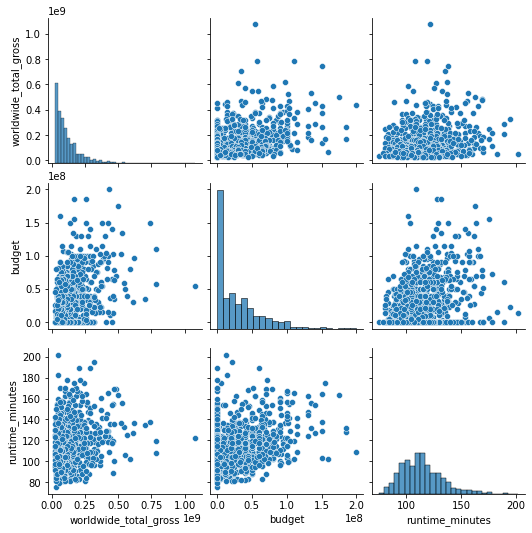

In [315]:
sns.pairplot(movie_data2)

In [384]:
movie_data4 = movie_data4.dropna()

In [385]:
movie_data4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 969 entries, 0 to 987
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   movie_title            969 non-null    object        
 1   year                   969 non-null    int64         
 2   worldwide_total_gross  969 non-null    int64         
 3   opening                969 non-null    int64         
 4   budget                 969 non-null    int64         
 5   runtime_minutes        969 non-null    float64       
 6   genres                 969 non-null    object        
 7   release_date           969 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 68.1+ KB


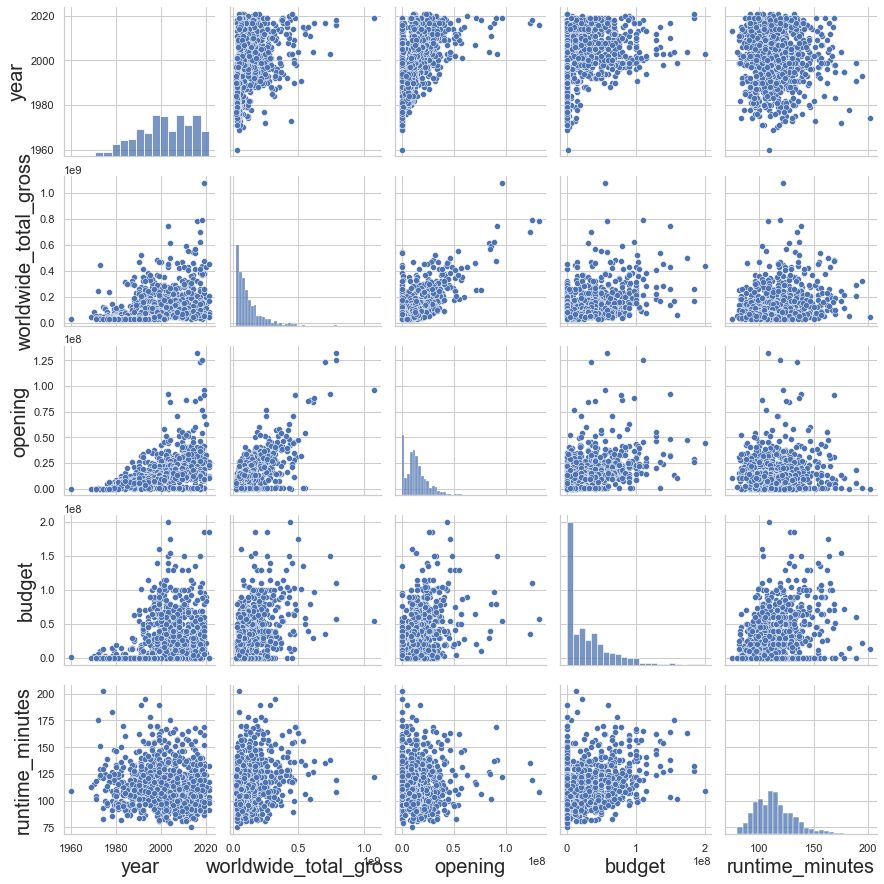

In [386]:
sns.pairplot(movie_data4)

In [335]:
movie_data3['worldgross/opening'] = movie_data3['opening'] / movie_data3['worldwide_total_gross']

In [344]:
movie_data3

,movie_title,year,worldwide_total_gross,opening,budget,runtime_minutes,genres,worldgross/opening
0,The Passion of the Christ,2004,612054506,83848082,30000000,127.0,1,0.136994
1,Deadpool,2016,782836791,132434639,58000000,108.0,1,0.169173
2,American Sniper,2014,547426372,633456,58800000,133.0,1,0.001157
3,Joker,2019,1074419384,96202337,55000000,122.0,1,0.089539
4,It,2017,701796444,123403419,35000000,135.0,1,0.175839
...,...,...,...,...,...,...,...,...
980,Moonlight,2016,65336603,402075,4000000,111.0,0,0.006154
981,Crank,2006,42931041,10457367,12000000,88.0,0,0.243585
983,Sinister 2,2015,53329150,10542116,10000000,97.0,0,0.197680
985,Oculus,2014,44459951,12005402,5000000,104.0,0,0.270027


In [342]:
movie_data3['genres'] = pd.get_dummies(movie_data3['genres'])

In [343]:
movie_data3

,movie_title,year,worldwide_total_gross,opening,budget,runtime_minutes,genres,worldgross/opening
0,The Passion of the Christ,2004,612054506,83848082,30000000,127.0,1,0.136994
1,Deadpool,2016,782836791,132434639,58000000,108.0,1,0.169173
2,American Sniper,2014,547426372,633456,58800000,133.0,1,0.001157
3,Joker,2019,1074419384,96202337,55000000,122.0,1,0.089539
4,It,2017,701796444,123403419,35000000,135.0,1,0.175839
...,...,...,...,...,...,...,...,...
980,Moonlight,2016,65336603,402075,4000000,111.0,0,0.006154
981,Crank,2006,42931041,10457367,12000000,88.0,0,0.243585
983,Sinister 2,2015,53329150,10542116,10000000,97.0,0,0.197680
985,Oculus,2014,44459951,12005402,5000000,104.0,0,0.270027


In [395]:
movie_data4

,movie_title,year,worldwide_total_gross,opening,budget,runtime_minutes,genres,release_date,months
0,The Passion of the Christ,2004,612054506,83848082,30000000,127.0,Drama,2004-02-25,2
1,Deadpool,2016,782836791,132434639,58000000,108.0,ActionAdventureComedySci-Fi,2016-02-09,2
2,American Sniper,2014,547426372,633456,58800000,133.0,ActionBiographyDramaWar,2014-12-25,12
3,Joker,2019,1074419384,96202337,55000000,122.0,CrimeDramaThriller,2019-10-02,10
4,It,2017,701796444,123403419,35000000,135.0,Horror,2017-09-06,9
...,...,...,...,...,...,...,...,...,...
983,Sinister 2,2015,53329150,10542116,10000000,97.0,HorrorMysteryThriller,2015-08-19,8
984,Internal Affairs,1990,27734391,5043516,0,115.0,CrimeDramaThriller,1990-01-12,1
985,Oculus,2014,44459951,12005402,5000000,104.0,HorrorMystery,2014-04-09,4
986,Saw VI,2009,68234154,14118444,11000000,90.0,HorrorMysteryThriller,2009-10-22,10


In [358]:
features, target = ['runtime_minutes'], 'worldwide_total_gross'
X, y = movie_data3[features], movie_data3[target]

lm = LinearRegression() # construct LinearRegression model object
lm.fit(X, y) #fit model to our choice of features

LinearRegression()

In [359]:
print(lm.intercept_)
print(lm.coef_)

-51283603.510599196
[1770339.73386802]


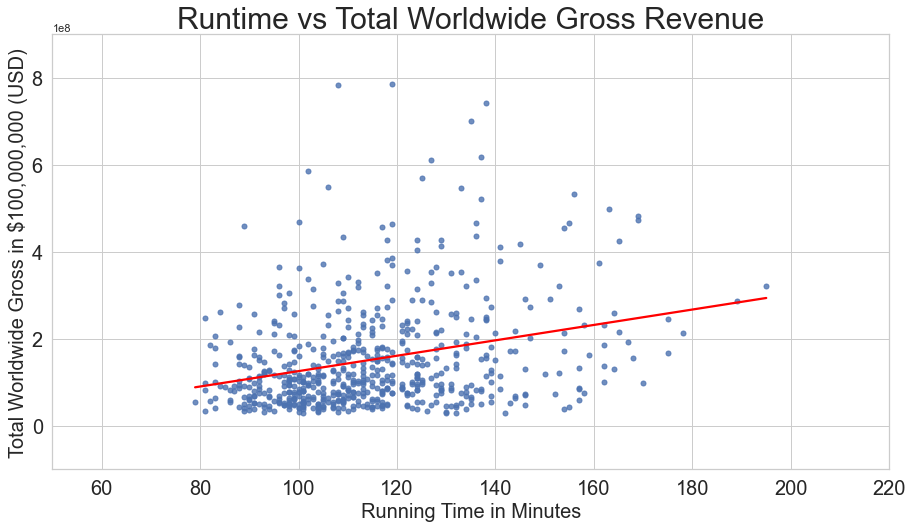

In [397]:
sns.set( rc = {'figure.figsize' : ( 15, 8 ),  
               'axes.labelsize' : 20 }) 
sns.set_style('whitegrid') 
sns.regplot(data = movie_data3, x = 'runtime_minutes', y = 'worldwide_total_gross', ci = 0, scatter_kws ={'s':25}, line_kws ={'color':'red'});
plt.title('Runtime vs Total Worldwide Gross Revenue', fontsize = 30);
plt.xlabel( "Running Time in Minutes" , size = 20 ) 
plt.ylabel( "Total Worldwide Gross in $100,000,000 (USD)" , size = 20 ) 
plt.ylim(-100000000, 900000000)
plt.xlim(50, 220)
plt.yticks(size = 20)
plt.xticks(size = 20)
plt.savefig('Comparing Running Time vs Total Domestic Gross Revenue.svg')

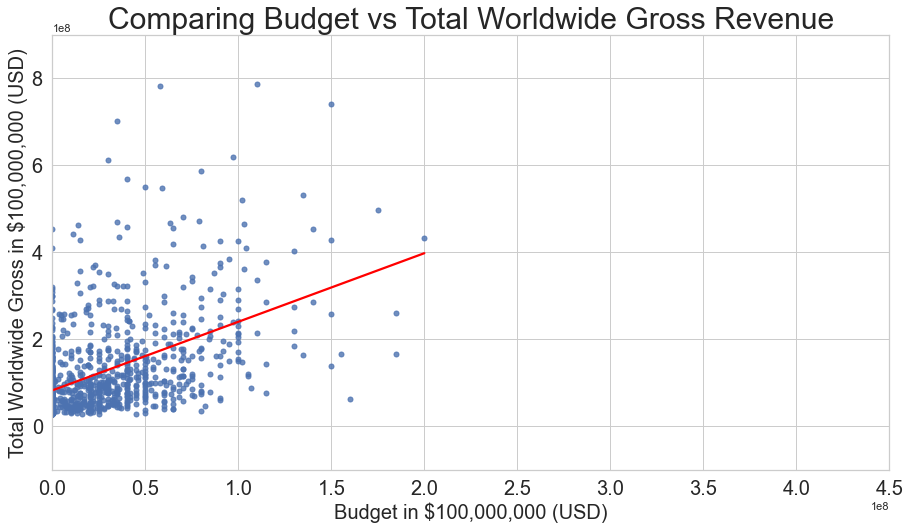

In [396]:
sns.set( rc = {'figure.figsize' : ( 15, 8 ),  
               'axes.labelsize' : 20 }) 
sns.set_style('whitegrid') 
sns.regplot(data = movie_data4, x = 'budget', y = 'worldwide_total_gross', ci = 0, scatter_kws ={'s':25}, line_kws ={'color':'red'});
plt.title('Comparing Budget vs Total Worldwide Gross Revenue', fontsize = 30);
plt.xlabel( "Budget in $100,000,000 (USD)" , size = 20 ) 
plt.ylabel( "Total Worldwide Gross in $100,000,000 (USD)" , size = 20 ) 
plt.ylim(-100000000, 900000000)
plt.xlim(0, 450000000)
plt.yticks(size = 20)
plt.xticks(size = 20)
plt.savefig('Comparing Budget vs Total Worldwide Gross Revenue.svg')

In [388]:
movie_data4['months'] = pd.DatetimeIndex(movie_data4['release_date']).month


In [392]:
movie_data4['year'].max()

2021

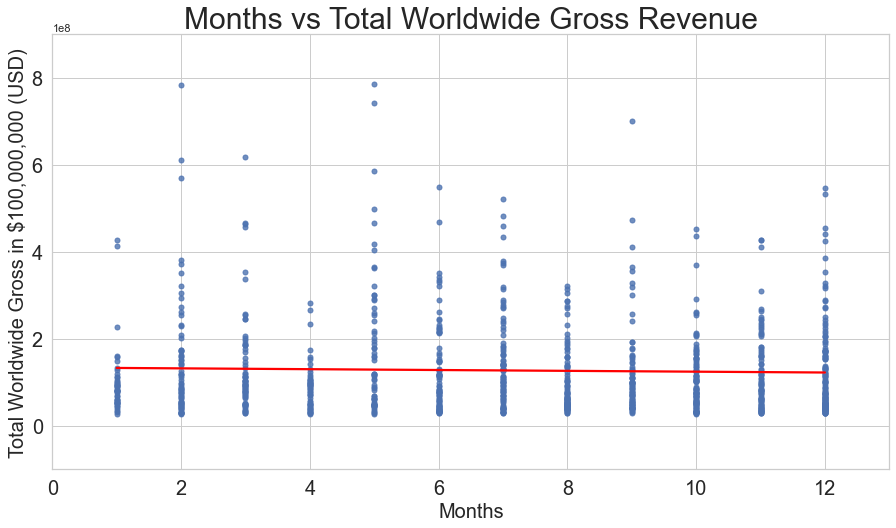

In [390]:
sns.set( rc = {'figure.figsize' : ( 15, 8 ),  
               'axes.labelsize' : 20 }) 
sns.set_style('whitegrid') 
sns.regplot(data = movie_data4, x = 'months', y = 'worldwide_total_gross', ci = 0, scatter_kws ={'s':25}, line_kws ={'color':'red'});
plt.title('Months vs Total Worldwide Gross Revenue', fontsize = 30);
plt.xlabel( "Months" , size = 20 ) 
plt.ylabel( "Total Worldwide Gross in $100,000,000 (USD)" , size = 20 ) 
plt.ylim(-100000000, 900000000)
plt.xlim(0, 13)
plt.yticks(size = 20)
plt.xticks(size = 20)
plt.savefig('Comparing Months vs Total Domestic Gross Revenue.svg')

In [398]:
features, target = ['months','budget','runtime_minutes'], 'worldwide_total_gross'
X, y = movie_data4[features], movie_data4[target]

lm = LinearRegression() # construct LinearRegression model object
lm.fit(X, y)

LinearRegression()

In [399]:
print(lm.intercept_)
print(lm.coef_)

4775920.874362528
[-1.48692927e+06  1.44216561e+00  8.08289329e+05]


<AxesSubplot:ylabel='worldwide_total_gross'>

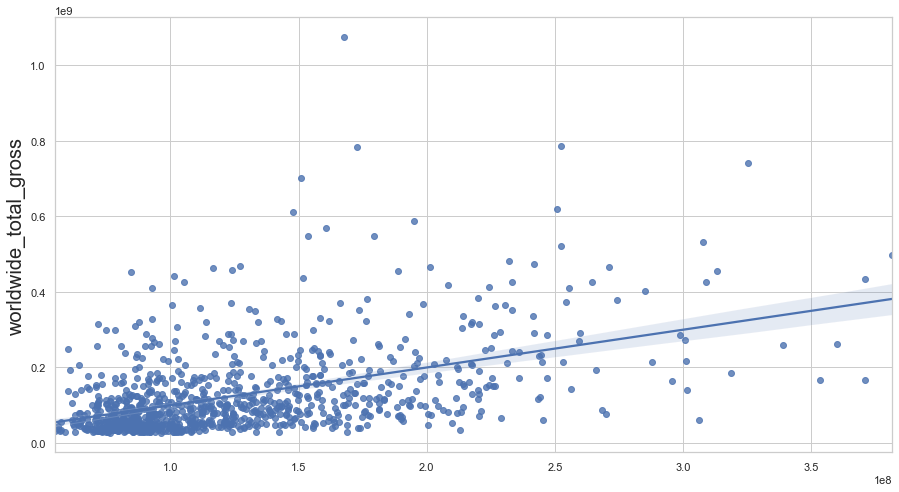

In [402]:
preds = lm.predict(X) # generate predictions (on training data) using fit model

sns.regplot(x=preds,y=y)